**Sloan Digital Sky Survey**

Многоклассовая классификация небесных объектов

100_000 наблюдений, каждое наблюдение описывается 42 признаками + целевой признак(звезда, галактика или квазар)

Тема: определить, что за небесный объект по его параметрам

Загрузка библиотек

In [ ]:
import os
import time
import json
import keras
import resource
import numpy as np
import pandas as pd
import seaborn as sns
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, classification_report

Загрузка датасета

In [ ]:
df = pd.read_csv('SDSS_DR18.csv')
df.head()

,objid,specobjid,ra,dec,u,g,r,i,z,run,...,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1.240000e+18,3.240000e+17,184.950869,0.733068,18.87062,17.59612,17.11245,16.83899,16.70908,756,...,19.96352,19.25145,19.05230,0.479021,0.518483,0.520474,0.508502,0.488969,0.041691,GALAXY
1,1.240000e+18,3.250000e+17,185.729201,0.679704,19.59560,19.92153,20.34448,20.66213,20.59599,756,...,19.92417,20.65535,20.57387,0.573926,0.531728,0.403072,0.999874,0.189495,-0.000814,STAR
2,1.240000e+18,3.240000e+17,185.687690,0.823480,19.26421,17.87891,17.09593,16.65159,16.35329,756,...,19.33645,18.16669,17.78844,0.701666,0.743386,0.770897,0.778642,0.736771,0.113069,GALAXY
3,1.240000e+18,2.880000e+18,185.677904,0.768362,19.49739,17.96166,17.41269,17.20545,17.11567,756,...,17.96176,17.21564,17.12367,0.999818,0.787760,0.745611,0.399718,0.986137,0.000087,STAR
4,1.240000e+18,2.880000e+18,185.814763,0.776940,18.31519,16.83033,16.26352,16.06320,15.97527,756,...,16.85104,16.08275,15.98694,0.999795,0.834450,0.723526,0.712259,0.527055,0.000018,STAR


Удаляем столбцы с ID наблюдений

In [ ]:
df = df.drop(['objid', 'specobjid'], axis=1)

Проверка пропущенных значений

In [ ]:
df.isnull().sum()

,0
ra,0
dec,0
u,0
g,0
r,0
i,0
z,0
run,0
rerun,0
camcol,0


Приводим целевую переменную в числовой вид и строим матрицу корреляции

<Axes: >

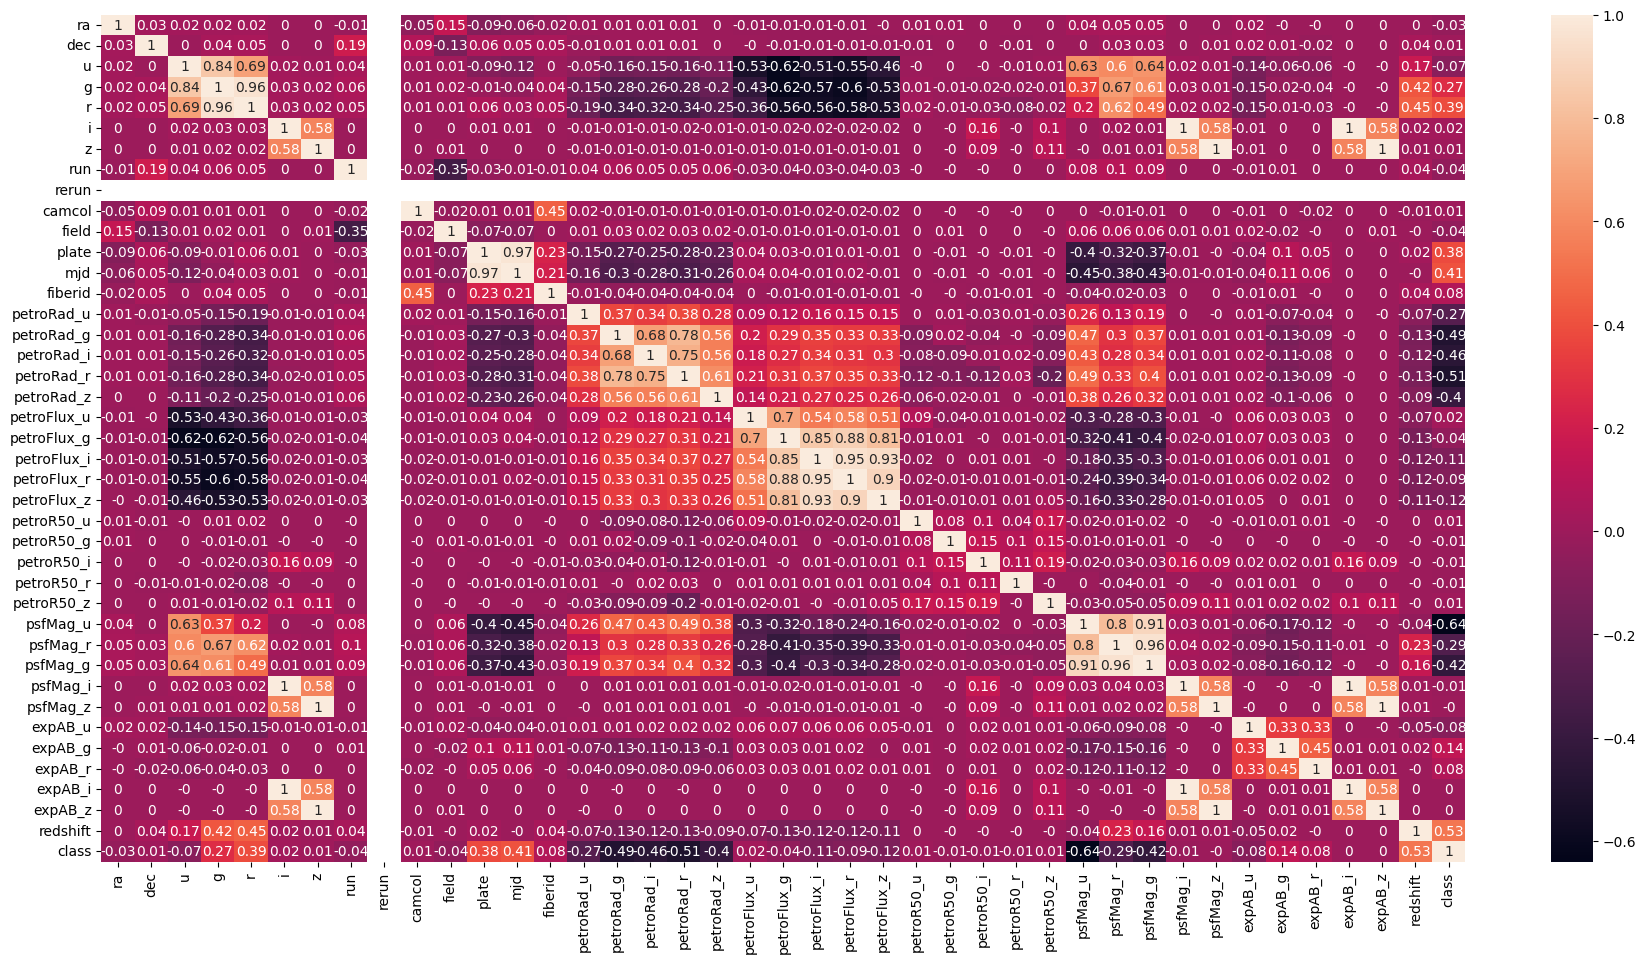

In [ ]:
df['class'], unique_labels = pd.factorize(df['class'])
correlation_matrix = df.corr().round(2)
plt.figure(figsize=(22, 11))
sns.heatmap(data=correlation_matrix, annot=True)

Смотрим, какие параметры больше всего коррелируют с целевой переменной

In [ ]:
target_corr = correlation_matrix['class'].abs().sort_values(ascending=False)
target_corr

,class
class,1.00
psfMag_u,0.64
redshift,0.53
petroRad_r,0.51
petroRad_g,0.49
petroRad_i,0.46
psfMag_g,0.42
mjd,0.41
petroRad_z,0.40
r,0.39


Удаляем параметры со слабой корреляцией

In [ ]:
top_features = target_corr[target_corr > 0.2]
top_features

,class
class,1.00
psfMag_u,0.64
redshift,0.53
petroRad_r,0.51
petroRad_g,0.49
petroRad_i,0.46
psfMag_g,0.42
mjd,0.41
petroRad_z,0.40
r,0.39


Создаем новый датафрейм с параметрами, которые хорошо коррелируют с целевой переменной

In [ ]:
df_top = df[top_features.keys()]
df_top

,class,psfMag_u,redshift,petroRad_r,petroRad_g,petroRad_i,psfMag_g,mjd,petroRad_z,r,plate,psfMag_r,g,petroRad_u
0,0,21.11891,0.041691,7.112749,7.004576,6.855976,19.96352,52000,6.930960,17.11245,288,19.50324,17.59612,7.282402
1,1,19.58945,-0.000814,1.266144,1.321027,1.167182,19.92417,51990,0.966431,20.34448,289,20.34491,19.92153,1.335305
2,0,20.82290,0.113069,4.057646,3.952013,4.007457,19.33645,52000,3.818449,17.09593,288,18.54832,17.87891,3.874802
3,1,19.49706,0.000087,1.281164,1.325716,1.176959,17.96176,54140,1.199375,17.41269,2558,17.42272,17.96166,1.251496
4,1,18.33505,0.000018,1.266766,1.336521,1.161740,16.85104,54140,1.239413,16.26352,2558,16.28580,16.83033,1.365736
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1,19.38800,-0.000101,1.357382,1.437838,1.253256,18.35865,54833,1.365813,18.00348,3177,18.01472,18.35476,9.782383
99996,1,19.06916,-0.000352,1.351257,1.468920,1.256501,18.06198,54833,1.363528,17.78332,3177,17.79733,18.05159,1.447653
99997,0,20.70439,0.117501,5.074382,5.484372,4.953245,19.05242,52407,4.858378,16.64037,946,18.14792,17.51349,6.156346
99998,1,17.27782,-0.000400,1.349462,1.467646,1.264171,16.42854,52072,1.272607,16.11662,617,16.10380,16.41704,1.552848


Делим данные на признаки и целевую переменную

In [ ]:
y = df_top['class']
X = df_top.drop(['class'], axis=1)

Делим на обучающую и тестовую выборки

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Нормализируем признаки

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Применяем One-Hot Encoding к целевой переменной, чтобы НС могла корректно их обрабатывать и обучаться

In [ ]:
Y_train_cat = keras.utils.to_categorical(Y_train, 3)
Y_test_cat = keras.utils.to_categorical(Y_test, 3)

**Создаем полносвязную НС**

Функция для создания настраиваемой модели НС

In [ ]:
def build_model(hp):
  model = keras.Sequential()
  for i in range(hp.Int('num_layers', 1, 2)):
    model.add(keras.layers.Dense(
        units=hp.Int(f'units_{i}', min_value=32, max_value=256, step=32),
        activation=hp.Choice(f'act_{i}', ['relu', 'leaky_relu', 'elu'])
        ))
    model.add(keras.layers.Dropout(hp.Float(f'dropout_{i}', 0.2, 0.5, step=0.1)))

  model.add(keras.layers.Dense(3, activation='softmax'));

  model.compile(
      optimizer=hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop']),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

Функция показывает кол-во используемой памяти

In [ ]:
def get_peak_memory_mb():
    return resource.getrusage(resource.RUSAGE_SELF).ru_maxrss / 1024.0

Класс для отслеживания ресурсов, используемых НС

In [ ]:
class ResourseMonitor(keras.callbacks.Callback):
  def __init__(self, log_file_path):
    super().__init__()
    self.log_file_path = log_file_path
    self.train_start_time = None
    self.max_memory_mb = 0
    self.history = {}

  def on_train_begin(self, logs=None):
    self.train_start_time = time.time()
    self.max_memory_mb = get_peak_memory_mb()
    self.history = {}

  def on_epoch_end(self, epoch, logs=None):
    current_peak_mem_mb = get_peak_memory_mb()
    self.max_memory_mb = max(self.max_memory_mb, current_peak_mem_mb)
    if logs:
      for key, value in logs.items():
        if key not in self.history:
          self.history[key] = []
        self.history[key].append(value)

  def on_train_end(self, logs=None):
    total_time = time.time() - self.train_start_time
    stats = {
        'time_seconds' : total_time,
        'max_memory_used(MB)': self.max_memory_mb,

    }
    for key, value in self.history.items():
      stats[f'final_{key}']= value[-1]

    existing_data = []

    if os.path.exists(self.log_file_path):
      try:
        with open(self.log_file_path, 'r') as f:
          existing_data = json.load(f)
        if not isinstance(existing_data, list):
          existing_data = []
      except json.JSONDecodeError:
        existing_data = []

    existing_data.append(stats)
    with open(self.log_file_path, 'w') as f:
      json.dump(existing_data, f, indent=2)

Находим оптимальные комбинации гиперпараметров НС

In [ ]:
keras_tuner_dir = 'keras_tuner_dir_resource_monitor'
project_name = 'my_model_tuning_with_resources'
resource_log_file = os.path.join(keras_tuner_dir, project_name, 'resources_summary.json')

os.makedirs(os.path.dirname(resource_log_file), exist_ok=True)

tuner = kt.RandomSearch(
    build_model,
    objective='accuracy',
    max_trials=10,
    directory=keras_tuner_dir,
    project_name=project_name
)


tuner.search(X_train_scaled, Y_train_cat, batch_size=128, epochs=10, validation_split = 0.2,callbacks=[ResourseMonitor(resource_log_file)])
best_model = tuner.get_best_models()[0]
best_params = tuner.get_best_hyperparameters()[0]
print(f'Найденные параметры: {best_params.values}')

Reloading Tuner from keras_tuner_dir_resource_monitor/my_model_tuning_with_resources/tuner0.json
Найденные параметры: {'num_layers': 2, 'units_0': 224, 'act_0': 'leaky_relu', 'dropout_0': 0.2, 'optimizer': 'adam', 'units_1': 256, 'act_1': 'leaky_relu', 'dropout_1': 0.30000000000000004}


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Структура найденной модели

In [ ]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (128, 224)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (128, 224)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (128, 256)             │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (128, 256)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (128, 3)               │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,507 (240.26 KB)

 Trainable params: 61,507 (240.26 KB)

 Non-trainable params: 0 (0.00 B)

Оценка модели на тестовых данных

In [ ]:
test_loss, test_acc = best_model.evaluate(X_test_scaled, Y_test_cat)
test_acc

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9452 - loss: 0.2586


0.94964998960495

Прогноз на новых входных данных

In [ ]:
y_pred = best_model.predict(X_test_scaled)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


Строим матрицу корреляции и выводим метрики

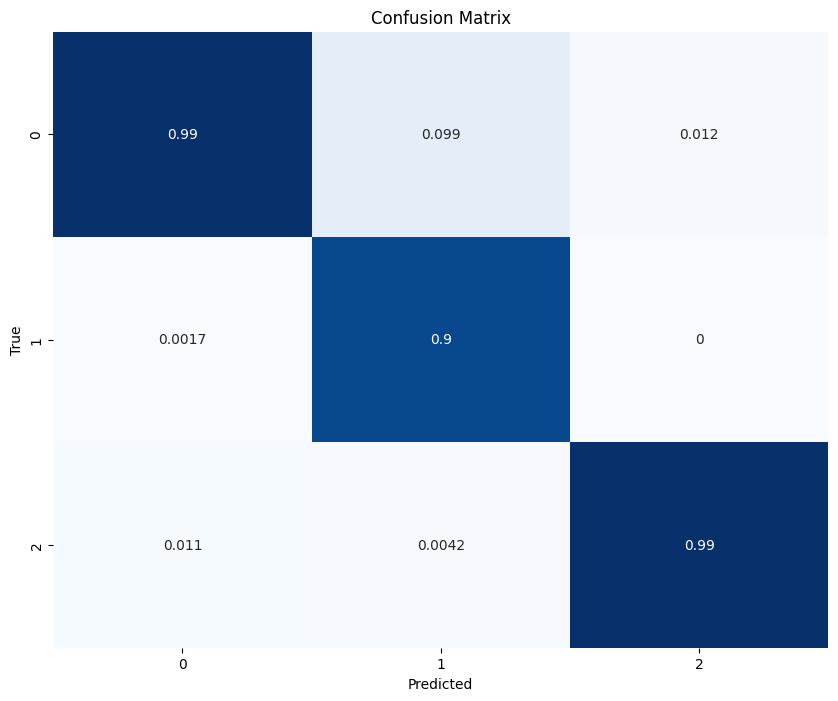

In [ ]:
ytrue = Y_test.astype(int).tolist()
y_prediction = np.argmax (y_pred, axis = 1)
res = confusion_matrix(ytrue, y_prediction , normalize='pred')
plt.figure(figsize=(10,8))
sns.heatmap(res, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(ytrue, y_prediction))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     10373
           1       0.90      1.00      0.94      7512
           2       0.99      0.93      0.96      2115

    accuracy                           0.95     20000
   macro avg       0.96      0.95      0.95     20000
weighted avg       0.95      0.95      0.95     20000



Accuracy: 95%, Модель верно предсказывает 95% случаем
Precision/Recall для класса 0(STAR):

*   Precision = 0.99: Из всех предсказанных звезд 99% верны
*   Recall = 0.99: Модель нашла 92% реальных звезд

Precision/Recall для класса 1(галактика):

*   Precision = 0.90: Из всех предсказанных галактик 90% верны
*   Recall = 1: Модель нашла 100% реальных галактик

Precision/Recall для класса 2(квазар):

*   Precision = 0.99: Из всех предсказанных квазаров 99% верны
*   Recall = 0.93: Модель нашла 93% реальных квазаров



**Сравнение с моделями машинного обучения**

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000, solver='lbfgs'),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)
}

Обучение моделей и вывод метрик

In [ ]:
for name, model in models.items():
  start_time = time.time()
  model.fit(X_train_scaled, Y_train)
  end_time = time.time()
  peak_mem_after_train = get_peak_memory_mb()

  train_time = end_time - start_time
  y_pred_model = model.predict(X_test_scaled)

  y_true_model = Y_test.astype(int).tolist()
  accuracy = accuracy_score(y_true_model, y_pred_model)

  print(f"Время обучения: {train_time:.4f} секунд")
  print(f"Пиковое использование памяти: {peak_mem_after_train:.2f} МБ")
  print(classification_report(y_true_model, y_pred_model))

Время обучения: 3.3448 секунд
Пиковое использование памяти: 1144.52 МБ
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10373
           1       0.99      1.00      0.99      7512
           2       0.98      0.95      0.97      2115

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.98     20000
weighted avg       0.99      0.99      0.99     20000

Время обучения: 69.7620 секунд
Пиковое использование памяти: 1144.52 МБ
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     10373
           1       1.00      1.00      1.00      7512
           2       0.99      0.95      0.97      2115

    accuracy                           0.99     20000
   macro avg       0.99      0.98      0.99     20000
weighted avg       0.99      0.99      0.99     20000



**Вывод**

Возможно, задача классификации небесных объектов проста и не требуются сложные нелинейные зависимости => данные линейно разделимы(те существует набор линейных границ, которые полностью отделяют каждый класс от остальных) и значит лучше в данном случае выбрать простую модель(Logistic Regression)(она и меньше ресурсов занимает и быстрее обучается)

**Дополнительный пример**

Модель многослойного перцептрона(по времени долго)

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=500, random_state=42, solver='adam', alpha=0.0001)

start_time = time.time()
mlp.fit(X_train_scaled, Y_train_cat)
end_time = time.time()
training_time = end_time - start_time
print(f"Время обучения: {training_time:.4f} секунд")

y_pred = mlp.predict(X_test_scaled)

accuracy_mlp = accuracy_score(Y_test_cat, y_pred)
print(accuracy_mlp)

Время обучения: 70.6552 секунд
0.99085
